In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 5.9 MB/s eta 0:00:00


**1. Importing Libraries:**

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from tqdm import tqdm, trange
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import metrics
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from catboost import CatBoostClassifier
import lightgbm as lgb
from imblearn.over_sampling import RandomOverSampler

import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf
cf.set_config_file(offline=True)
# Input data files are available i

import datetime

import tensorflow as tf
from tensorflow import keras
from keras import layers

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


**2. Data exploration**

In [4]:
train_f = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/energy-anomaly-detection/train_features.csv')
train_f.shape

(1749494, 57)

In [5]:
train_f.head()

,building_id,timestamp,meter_reading,anomaly,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,...,gte_meter,gte_meter_hour,gte_meter_weekday,gte_meter_month,gte_meter_building_id,gte_meter_primary_use,gte_meter_site_id,gte_meter_building_id_hour,gte_meter_building_id_weekday,gte_meter_building_id_month
0,1,2016-01-01 00:00:00,NaN,0,0,Education,2720,104,0,19.4,...,4.116,3.981,4.146,4.12,3.569,4.489,4.079,3.554,3.538,3.845
1,32,2016-01-01 00:00:00,NaN,0,0,Office,48392,105,0,19.4,...,4.116,3.981,4.146,4.12,4.513,4.211,4.079,4.128,4.579,4.317
2,41,2016-01-01 00:00:00,NaN,0,0,Office,93860,68,0,19.4,...,4.116,3.981,4.146,4.12,4.108,4.211,4.079,4.103,4.140,4.114
3,55,2016-01-01 00:00:00,NaN,0,0,Office,16726,111,0,19.4,...,4.116,3.981,4.146,4.12,3.506,4.211,4.079,3.308,3.565,3.813
4,69,2016-01-01 00:00:00,NaN,0,0,Parking,387638,100,0,19.4,...,4.116,3.981,4.146,4.12,3.035,3.623,4.079,3.892,3.090,3.577


checking for missing values

In [6]:
for column in train_f.columns:
    k = train_f[column].isnull().sum()
    if k > 0:
        print(f'{column} : {k}')

meter_reading : 107653


only meter_reading column has null values

In [7]:
train_f[train_f['anomaly']==1].isnull().sum()

,0
building_id,0
timestamp,0
meter_reading,0
anomaly,0
site_id,0
primary_use,0
square_feet,0
year_built,0
floor_count,0
air_temperature,0


There are no instances where an anomalous case has a null meter_reading.

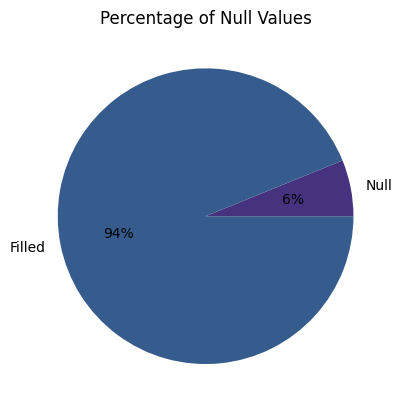

In [8]:
missing_values = train_f.isnull().sum().sum()
plt.pie([missing_values, train_f.shape[0]-missing_values], labels=['Null', 'Filled']\
        , colors=sb.color_palette('viridis'), autopct='%.0f%%')
plt.title('Percentage of Null Values')
plt.show()

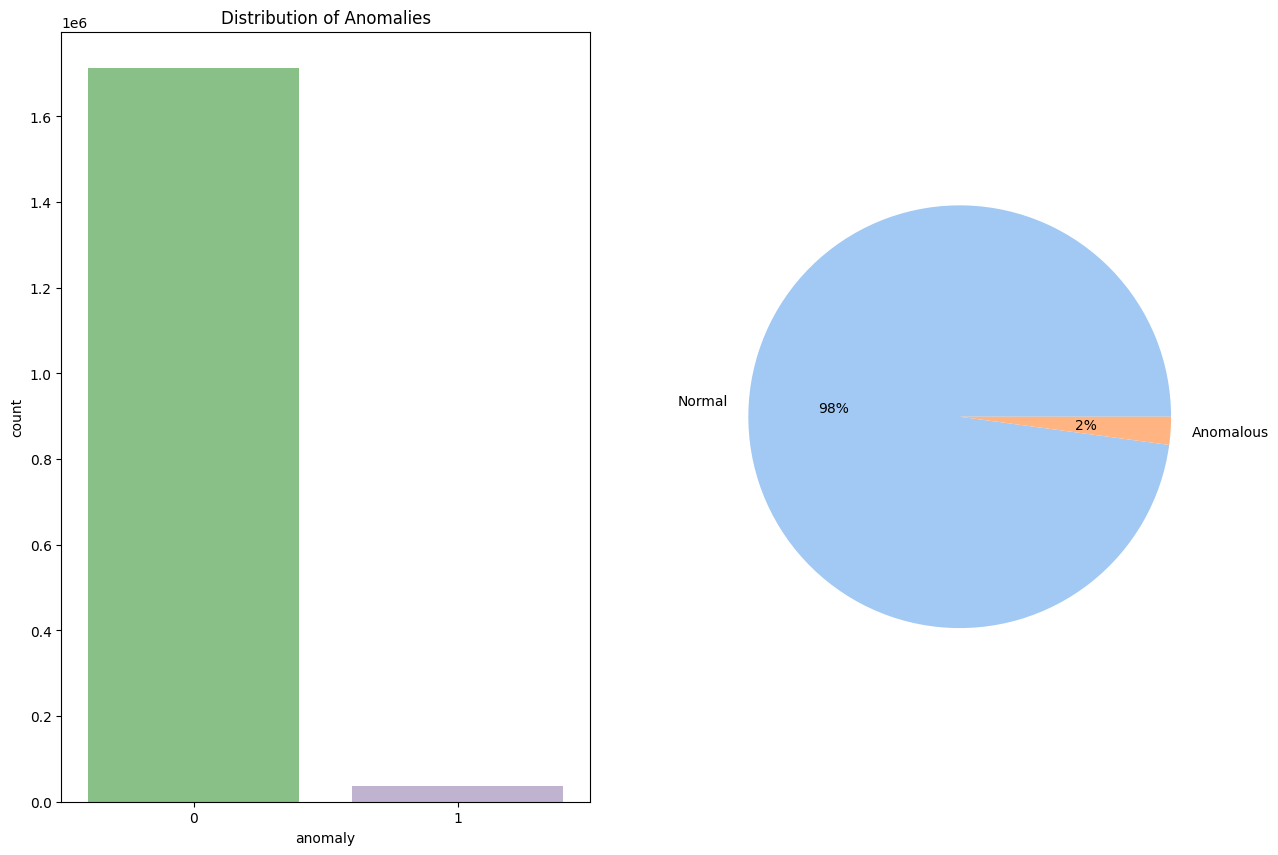

In [9]:
plt.subplots(figsize=(15,10))
plt.subplot(1,2,1)
sb.countplot(x=train_f['anomaly'], palette= 'Accent')
plt.title('Distribution of Anomalies')
plt.subplot(1,2,2)
data = train_f['anomaly'].value_counts()
plt.pie(data, labels=['Normal', 'Anomalous'], colors=sb.color_palette('pastel'), autopct='%.0f%%')

plt.show()

In [10]:
train_f[train_f['meter_reading']==1.0]['anomaly'].value_counts()


,count
anomaly,
1,17053
0,6


In [11]:
for idx in tqdm(train_f['building_id'].unique()):
    if train_f[train_f['building_id']==idx]['primary_use'].nunique()>1:
        print(idx)

100%|██████████| 200/200 [00:04<00:00, 44.97it/s]


the above code identifies and prints building_id values that are associated with multiple unique primary_use values.

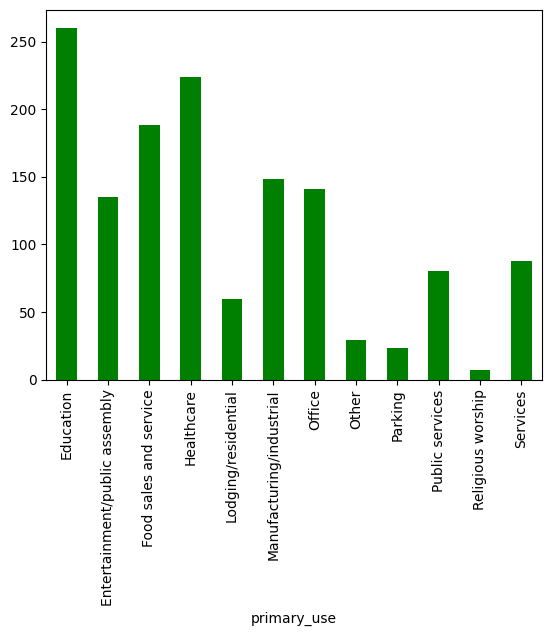

In [12]:
meanbyUse = train_f.groupby('primary_use')['meter_reading'].mean()
meanbyUse.plot.bar(color ='g')
plt.show()

the above code calculates the average meter reading for each type of primary use and visualizes the results in a bar chart.

In [13]:
ints = []
objects = []
floats = []

for column in train_f.columns:
    if train_f[column].dtype == int:
        ints.append(column)
    elif train_f[column].dtype == object:
        objects.append(column)
    else:
        floats.append(column)

the above code separates the column names of the train DataFrame into three lists based on whether their data types are integers, objects, or floats.

In [14]:
ints

['building_id',
 'anomaly',
 'site_id',
 'square_feet',
 'year_built',
 'floor_count',
 'cloud_coverage',
 'precip_depth_1_hr',
 'wind_direction',
 'hour',
 'weekday',
 'month',
 'year',
 'is_holiday']

In [15]:
train_f[ints].nunique()

,0
building_id,200
anomaly,2
site_id,14
square_feet,200
year_built,32
floor_count,12
cloud_coverage,11
precip_depth_1_hr,128
wind_direction,44
hour,24


Above code outputs a Series where the index consists of the names of integer columns from train, and the values are the counts of unique values in each of these columns.

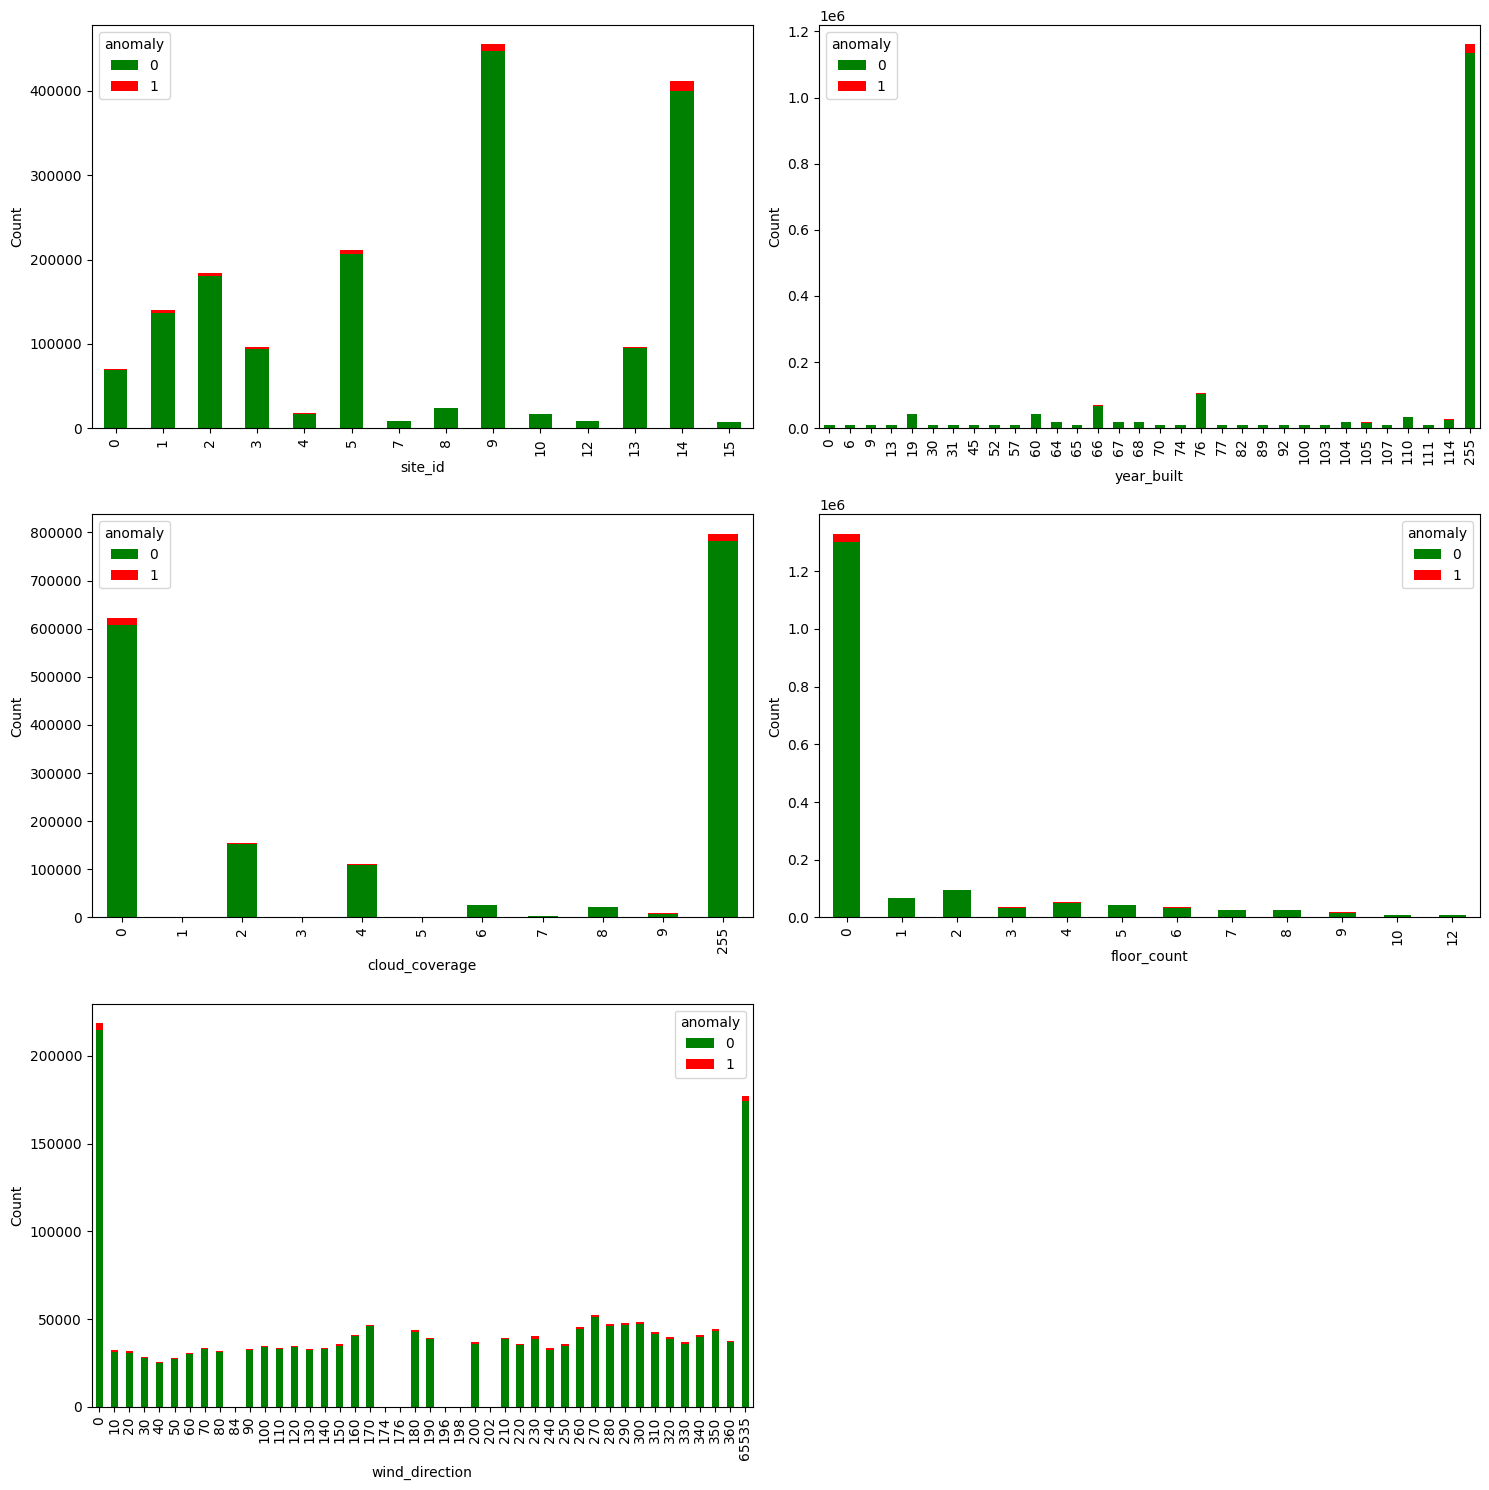

In [16]:
plt.subplots(figsize=(15,15))
sample = ['site_id', 'year_built', 'cloud_coverage', 'floor_count', 'wind_direction']

for i, column in enumerate(sample):
    plt.subplot(3,2,i+1)
    # Creating a cross-tabulation of 'column' and 'anomaly'
    ct = pd.crosstab(train_f[column], train_f['anomaly'])
    # Plot the stacked bar chart
    ct.plot(kind='bar', color = ['Green', 'Red'], stacked=True, ax=plt.gca())
    plt.xlabel(column)
    plt.ylabel('Count')

plt.tight_layout()
plt.show()

In [17]:
train_f['year_built'].value_counts()

,count
year_built,
255,1161101
76,105408
66,70271
19,43920
60,43919
110,35058
114,26345
105,17568
104,17568


In [18]:
train_f['cloud_coverage'].value_counts()

,count
cloud_coverage,
255,797545
0,622994
2,155730
4,111173
6,26337
8,22152
9,8231
7,3485
1,713


a value like 255 might be used as a placeholder for missing or invalid data. Replacing it with 10 can be part of cleaning the data to make it more meaningful or consistent.

**Feature Engineering:**

In [19]:
train_f['cloud_coverage'] = train_f['cloud_coverage'].replace({255:10})
train_f.head()

,building_id,timestamp,meter_reading,anomaly,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,...,gte_meter,gte_meter_hour,gte_meter_weekday,gte_meter_month,gte_meter_building_id,gte_meter_primary_use,gte_meter_site_id,gte_meter_building_id_hour,gte_meter_building_id_weekday,gte_meter_building_id_month
0,1,2016-01-01 00:00:00,NaN,0,0,Education,2720,104,0,19.4,...,4.116,3.981,4.146,4.12,3.569,4.489,4.079,3.554,3.538,3.845
1,32,2016-01-01 00:00:00,NaN,0,0,Office,48392,105,0,19.4,...,4.116,3.981,4.146,4.12,4.513,4.211,4.079,4.128,4.579,4.317
2,41,2016-01-01 00:00:00,NaN,0,0,Office,93860,68,0,19.4,...,4.116,3.981,4.146,4.12,4.108,4.211,4.079,4.103,4.140,4.114
3,55,2016-01-01 00:00:00,NaN,0,0,Office,16726,111,0,19.4,...,4.116,3.981,4.146,4.12,3.506,4.211,4.079,3.308,3.565,3.813
4,69,2016-01-01 00:00:00,NaN,0,0,Parking,387638,100,0,19.4,...,4.116,3.981,4.146,4.12,3.035,3.623,4.079,3.892,3.090,3.577


In [20]:
for column in train_f.columns:
    if train_f[column].nunique()==1:
        print(column, train_f[column].dtype)

year int64
gte_meter float64


In [21]:
train_f['date'] = pd.to_datetime(train_f['timestamp']).dt.date
train_f['meterReadings_daily_std'] = train_f.groupby(['building_id','date'])['meter_reading'].transform('std')

Above code extracts the date from the timestamp column and calculates the standard deviation of the meter_reading values for each building on each day. The standard deviation values are stored in the new column meterReadings_daily_std.

In [22]:
train_f = train_f.drop(['timestamp', 'year', 'gte_meter'], axis=1)

Above code updates the train DataFrame by removing the columns timestamp, year, and gte_meter.

In [23]:
objects

['timestamp',
 'primary_use',
 'weekday_hour',
 'building_weekday_hour',
 'building_weekday',
 'building_month',
 'building_hour',
 'building_meter']

In [24]:
train_f['building_month'].unique()

array(['1-0-1', '32-0-1', '41-0-1', ..., '1353-0-12', '827-0-12',
       '848-0-12'], dtype=object)

In [25]:
train_f = train_f.drop(objects[2:], axis=1)
print(train_f.shape)

(1749494, 50)


In [26]:
floats

['meter_reading',
 'air_temperature',
 'dew_temperature',
 'sea_level_pressure',
 'wind_speed',
 'air_temperature_mean_lag7',
 'air_temperature_max_lag7',
 'air_temperature_min_lag7',
 'air_temperature_std_lag7',
 'air_temperature_mean_lag73',
 'air_temperature_max_lag73',
 'air_temperature_min_lag73',
 'air_temperature_std_lag73',
 'hour_x',
 'hour_y',
 'month_x',
 'month_y',
 'weekday_x',
 'weekday_y',
 'gte_hour',
 'gte_weekday',
 'gte_month',
 'gte_building_id',
 'gte_primary_use',
 'gte_site_id',
 'gte_meter',
 'gte_meter_hour',
 'gte_meter_weekday',
 'gte_meter_month',
 'gte_meter_building_id',
 'gte_meter_primary_use',
 'gte_meter_site_id',
 'gte_meter_building_id_hour',
 'gte_meter_building_id_weekday',
 'gte_meter_building_id_month']

Imputing nulls:

In [27]:
def fill_missing_values(data):
    average_readings = data.groupby('building_id')['meter_reading'].mean()

    building_id = average_readings.index
    values = average_readings.values

    for i, idx in tqdm(enumerate(building_id)):
        data[data['building_id']==idx] = data[data['building_id']==idx].fillna(values[i])

    return data

train_f = fill_missing_values(train_f)

200it [00:10, 18.88it/s]


By Grouping the data by building_id and calculating the mean of the meter_reading for each building, this mean value will be used to fill in any missing meter_reading values within that specific building. For each building, identified by its building_id, the code checks if there are any missing values (NaN) in the meter_reading column.If there are missing values, it fills these with the mean meter_reading calculated in the first step for that particular building. The dataset is then updated in place with the filled values. Finally, the function returns the updated dataset where all missing meter_reading values have been replaced with the mean values specific to each building.

**Highly correlated features**

The code converts object-type columns to datetime format where possible. It then selects numerical features from the DataFrame. Finally, it generates and displays a heatmap showing which pairs of numerical features have a correlation greater than 0.95.

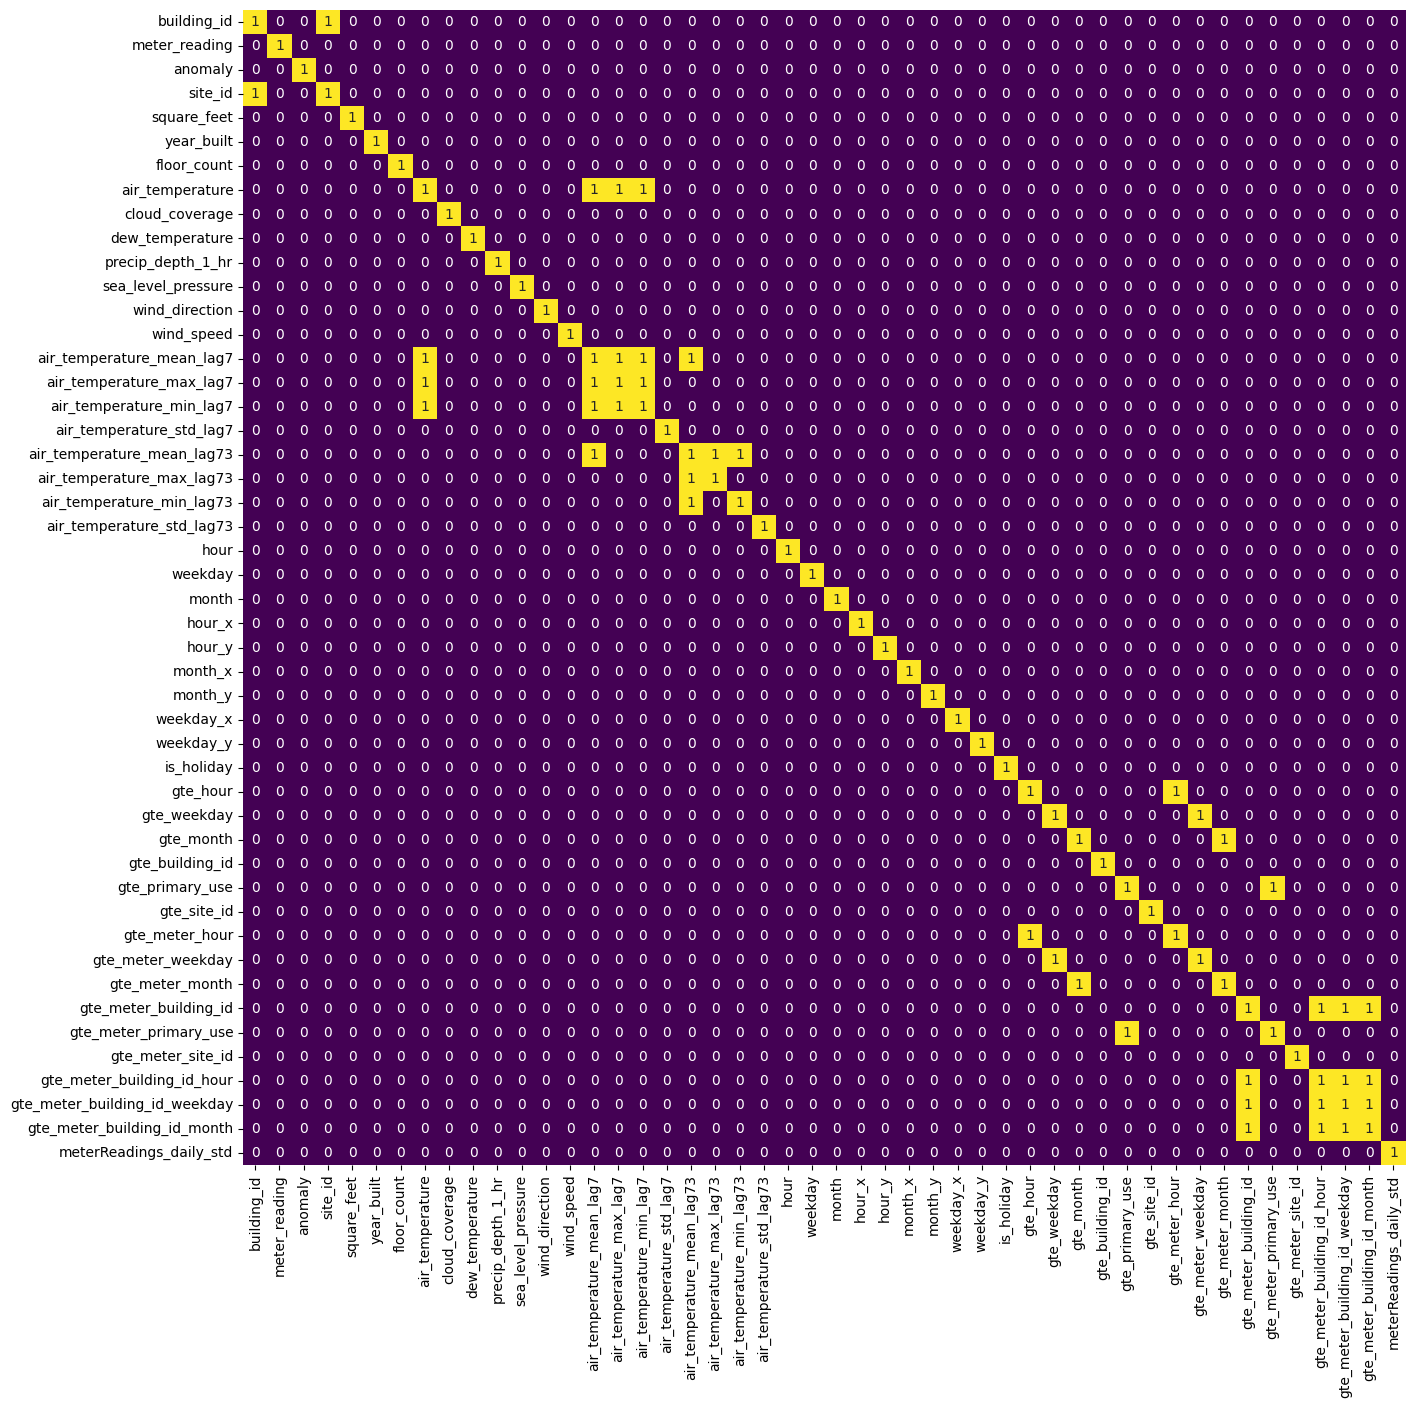

In [28]:
# Converting date columns to datetime objects
for column in train_f.columns:
    if train_f[column].dtype == 'object':  # Checking if the column has object dtype
        try:
            train_f[column] = pd.to_datetime(train_f[column])
        except:
            pass

# Now extract numerical features for correlation analysis
numerical_features = train_f.select_dtypes(include=['number'])

plt.figure(figsize=(15, 15))
sb.heatmap(numerical_features.corr() > 0.95, annot=True, cbar=False, cmap ='viridis')
plt.show()

In [29]:
train_f.columns

Index(['building_id', 'meter_reading', 'anomaly', 'site_id', 'primary_use',
       'square_feet', 'year_built', 'floor_count', 'air_temperature',
       'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr',
       'sea_level_pressure', 'wind_direction', 'wind_speed',
       'air_temperature_mean_lag7', 'air_temperature_max_lag7',
       'air_temperature_min_lag7', 'air_temperature_std_lag7',
       'air_temperature_mean_lag73', 'air_temperature_max_lag73',
       'air_temperature_min_lag73', 'air_temperature_std_lag73', 'hour',
       'weekday', 'month', 'hour_x', 'hour_y', 'month_x', 'month_y',
       'weekday_x', 'weekday_y', 'is_holiday', 'gte_hour', 'gte_weekday',
       'gte_month', 'gte_building_id', 'gte_primary_use', 'gte_site_id',
       'gte_meter_hour', 'gte_meter_weekday', 'gte_meter_month',
       'gte_meter_building_id', 'gte_meter_primary_use', 'gte_meter_site_id',
       'gte_meter_building_id_hour', 'gte_meter_building_id_weekday',
       'gte_meter_building_id_mon

removing specific columns

In [30]:
high_corr = [#'building_id',
         #'site_id',
 #'year_built',
 #'square_feet',
 'primary_use',
 #'floor_count',
 #'precip_depth_1_hr', 'sea_level_pressure',
 #'wind_direction', 'wind_speed',
 'gte_meter_hour',
 'gte_meter_weekday',
 'gte_meter_month',
 'gte_meter_building_id',
 'gte_meter_primary_use',
 'gte_meter_site_id',
 'gte_meter_building_id_hour',
 'gte_meter_building_id_weekday',
 'gte_meter_building_id_month',
 'air_temperature_mean_lag73',
 'air_temperature_max_lag73',
 'air_temperature_min_lag73',
 'air_temperature_mean_lag7',
 'air_temperature_max_lag7',
 'air_temperature_min_lag7']

train_f = train_f.drop(high_corr, axis=1)
train_f.shape

(1749494, 34)

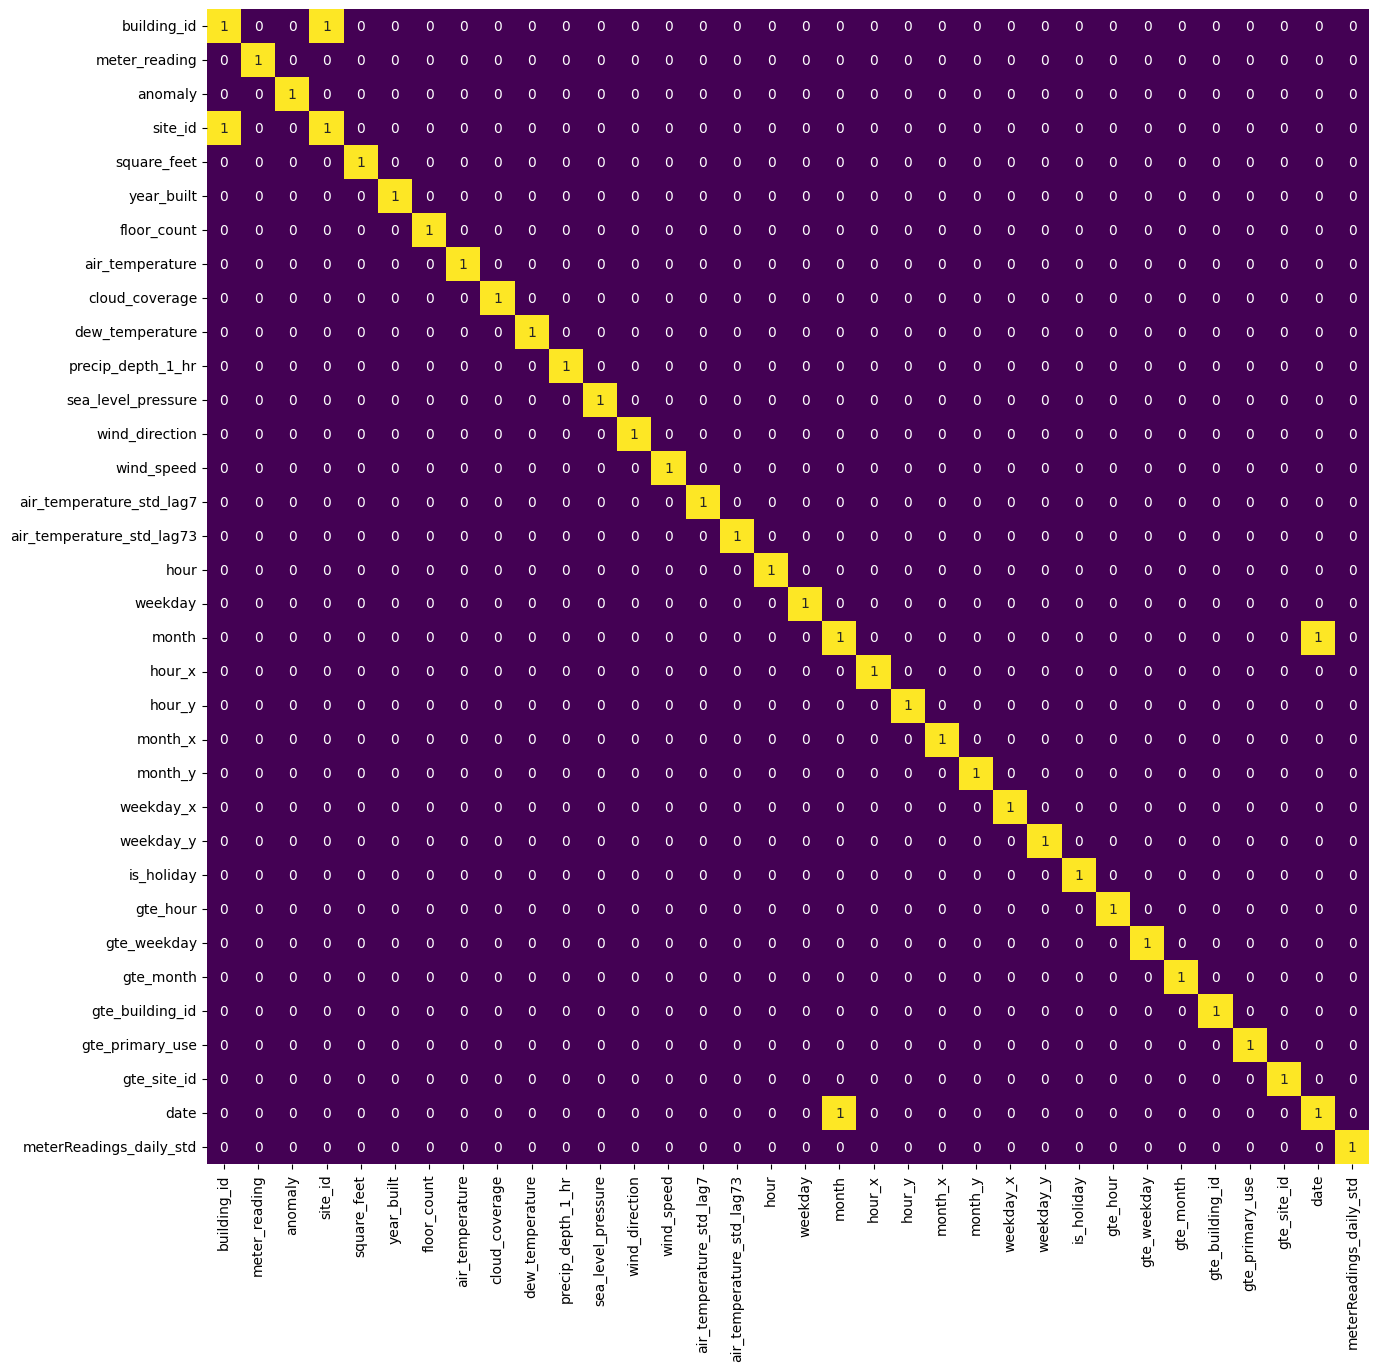

In [31]:
plt.figure(figsize=(15,15))
sb.heatmap(train_f.corr() > 0.75, annot=True, cbar=False, cmap='viridis')
plt.show()

**4. Model:**

In [32]:
test_f = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/energy-anomaly-detection/test_features.csv', index_col=0)
test_f = fill_missing_values(test_f)
test_f['cloud_coverage'] = test_f['cloud_coverage'].replace({255:10})

test_f['date'] = pd.to_datetime(test_f['timestamp']).dt.date
test_f['meterReadings_daily_std'] = test_f.groupby(['building_id','date'])['meter_reading'].transform('std')

test_f = test_f.drop(['timestamp', 'year', 'gte_meter'] + objects[2:] + high_corr, axis=1)

206it [00:30,  6.70it/s]


In [33]:
test_f.describe()

,building_id,meter_reading,site_id,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,...,weekday_x,weekday_y,is_holiday,gte_hour,gte_weekday,gte_month,gte_building_id,gte_primary_use,gte_site_id,meterReadings_daily_std
count,1.800567e+06,1.800567e+06,1.800567e+06,1.800567e+06,1.800567e+06,1.800567e+06,1.800567e+06,1.800567e+06,1.800567e+06,1.800567e+06,...,1.800567e+06,1.800567e+06,1.800567e+06,1.800567e+06,1.800567e+06,1.800567e+06,1.800567e+06,1.800567e+06,1.800567e+06,1.800561e+06
mean,8.040281e+02,1.759617e+02,7.912157e+00,1.019317e+05,1.953569e+02,8.537594e-01,1.651532e+01,5.176040e+00,8.779221e+00,1.255604e-01,...,3.087368e-03,3.580333e-03,2.736638e-02,4.350136e+00,4.350108e+00,4.350077e+00,4.278809e+00,4.378195e+00,4.402207e+00,2.336211e+01
std,4.130023e+02,2.836115e+02,4.861850e+00,1.203122e+05,8.709273e+01,2.095721e+00,1.032139e+01,4.618847e+00,9.885269e+00,6.075749e+00,...,7.069468e-01,7.073290e-01,1.631486e-01,1.405354e-01,6.781276e-02,4.255337e-02,1.520180e+00,3.490425e-01,7.518568e-01,1.001854e+02
min,1.800000e+01,0.000000e+00,0.000000e+00,1.102000e+03,4.000000e+00,0.000000e+00,-2.990000e+01,0.000000e+00,-3.600000e+01,-2.000000e+00,...,-1.000000e+00,-1.000000e+00,0.000000e+00,4.128000e+00,4.234000e+00,4.297000e+00,8.900000e-01,2.929000e+00,2.670000e+00,0.000000e+00
25%,4.760000e+02,2.500000e+01,3.000000e+00,2.836300e+04,8.900000e+01,0.000000e+00,9.000000e+00,0.000000e+00,1.700000e+00,-1.000000e+00,...,-7.070000e-01,-7.070000e-01,0.000000e+00,4.220000e+00,4.254000e+00,4.302000e+00,3.278000e+00,4.342000e+00,4.174000e+00,3.523174e+00
50%,9.180000e+02,7.140000e+01,9.000000e+00,5.819600e+04,2.550000e+02,0.000000e+00,1.670000e+01,4.000000e+00,9.400000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,4.384000e+00,4.386000e+00,4.338000e+00,4.195000e+00,4.342000e+00,4.710000e+00,1.080462e+01
75%,1.223000e+03,2.017100e+02,1.400000e+01,1.305770e+05,2.550000e+02,0.000000e+00,2.440000e+01,1.000000e+01,1.670000e+01,0.000000e+00,...,7.070000e-01,7.070000e-01,0.000000e+00,4.497000e+00,4.399000e+00,4.396000e+00,5.431000e+00,4.615000e+00,4.744000e+00,2.892506e+01
max,1.425000e+03,7.976900e+04,1.500000e+01,8.503540e+05,2.550000e+02,1.300000e+01,4.720000e+01,1.000000e+01,2.610000e+01,3.430000e+02,...,1.000000e+00,1.000000e+00,1.000000e+00,4.519000e+00,4.401000e+00,4.424000e+00,7.802000e+00,5.359000e+00,5.148000e+00,1.690544e+04


In [34]:
print(train_f.shape, test_f.shape)

(1749494, 34) (1800567, 33)


In [35]:
train_f = train_f.drop(['date','meterReadings_daily_std'],axis=1)
test_f = test_f.drop(['date','meterReadings_daily_std'],axis=1)

In [36]:
print(train_f.shape, test_f.shape)

(1749494, 32) (1800567, 31)


creating a balanced dataset for training, ensuring that the number of positive and negative samples is more balanced, which is often necessary for anomaly detection tasks to avoid model bias toward the majority class.

In [37]:
negative_examples = train_f[train_f['anomaly'] == 0]
positive_examples = train_f[train_f['anomaly'] == 1]


print(negative_examples.shape, positive_examples.shape)
negative_sample1 = negative_examples.sample(n = 37296, random_state=10)
negative_sample2 = negative_examples.sample(n = 37296, random_state=20)
balanced_dataset = pd.concat([negative_sample1, positive_examples, negative_sample2, positive_examples], axis=0)
print(balanced_dataset.shape)

(1712198, 32) (37296, 32)
(149184, 32)


In [38]:
feature_set = balanced_dataset.drop(['anomaly'], axis=1)
target_variable = balanced_dataset['anomaly']

In [39]:
feature_set.columns

Index(['building_id', 'meter_reading', 'site_id', 'square_feet', 'year_built',
       'floor_count', 'air_temperature', 'cloud_coverage', 'dew_temperature',
       'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction',
       'wind_speed', 'air_temperature_std_lag7', 'air_temperature_std_lag73',
       'hour', 'weekday', 'month', 'hour_x', 'hour_y', 'month_x', 'month_y',
       'weekday_x', 'weekday_y', 'is_holiday', 'gte_hour', 'gte_weekday',
       'gte_month', 'gte_building_id', 'gte_primary_use', 'gte_site_id'],
      dtype='object')

In [40]:
X_train_f, X_val_f, Y_train_f, Y_val_f = train_test_split(feature_set, target_variable, test_size = 0.20, random_state=10)
print(X_train_f.shape, X_val_f.shape)

(119347, 31) (29837, 31)


In [41]:
scaler = StandardScaler()
X_train_f = scaler.fit_transform(X_train_f)
X_val_f = scaler.transform(X_val_f)
test1 = scaler.transform(test_f)

In [56]:
models = [XGBClassifier(), lgb.LGBMClassifier(), HistGradientBoostingClassifier(), CatBoostClassifier(verbose=0)]

for i in range(4):
    models[i].fit(X_train_f, Y_train_f)

    print(f'{models[i]} : ')
    print('Training Accuracy : ', metrics.roc_auc_score(Y_train_f, models[i].predict_proba(X_train_f)[:,1]))
    print('Validation Accuracy : ', metrics.roc_auc_score(Y_val_f, models[i].predict_proba(X_val_f)[:,1]))
    print()


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...) : 
Training Accuracy :  0.9954079168142107
Validation Accuracy :  0.9905960565186798

[LightGBM] [Info] Number of positive: 59598, number of negative: 59749
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...) : 
Training Accuracy :  0.9954079168142107
Validation Accuracy :  0.9905960565186798
[LightGBM] [Info] Number of positive: 59598, number of negative: 59749
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 

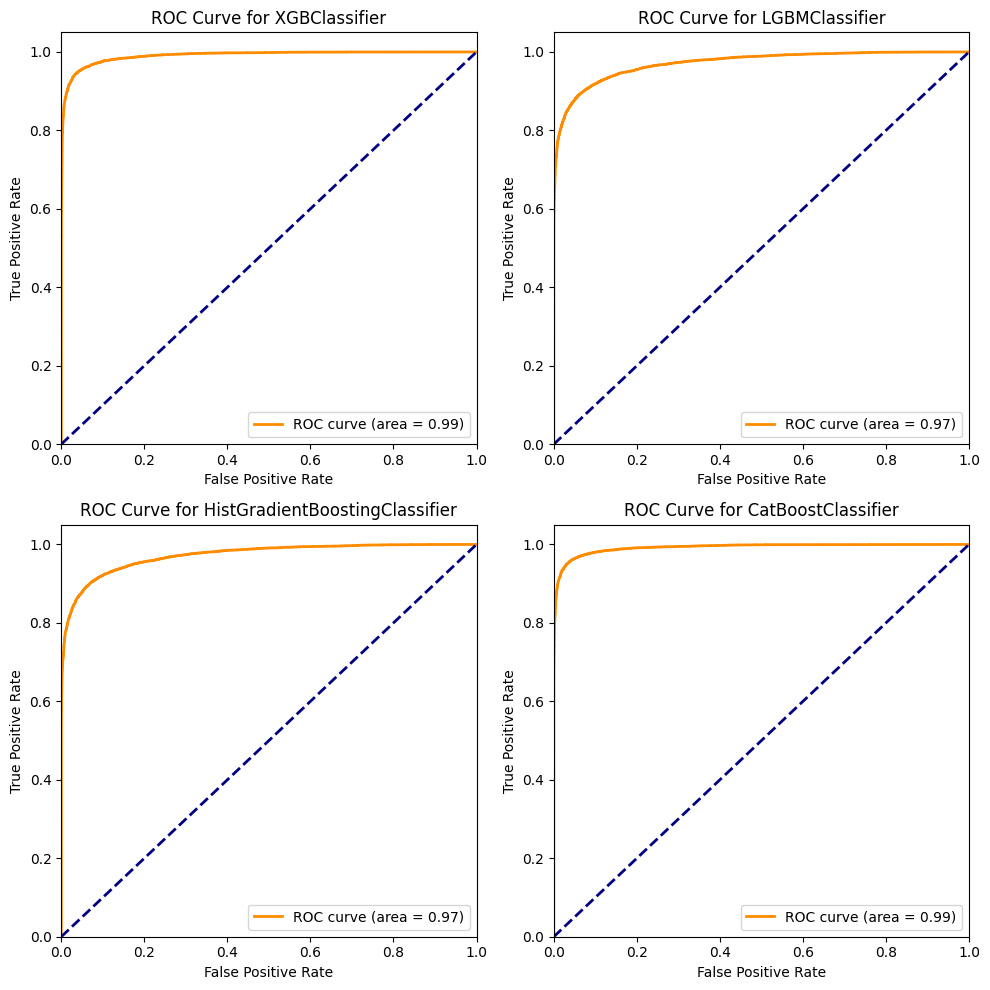

In [59]:
from sklearn.metrics import roc_curve, auc

models = [XGBClassifier(), lgb.LGBMClassifier(), HistGradientBoostingClassifier(), CatBoostClassifier(verbose=0)]
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

for i in range(4):
    models[i].fit(X_train_f, Y_train_f)
    val_predictions = models[i].predict_proba(X_val_f)[:, 1]
    print(f'{models[i]} : ')
    print('Training Accuracy : ', metrics.roc_auc_score(Y_train_f, models[i].predict_proba(X_train_f)[:,1]))
    print('Validation Accuracy : ', metrics.roc_auc_score(Y_val_f, models[i].predict_proba(X_val_f)[:,1]))

    fpr, tpr, thresholds = roc_curve(Y_val_f, val_predictions)
    roc_auc = auc(fpr, tpr)

    row = i // 2  # Calculate row index for 2x2 grid
    col = i % 2   # Calculate column index for 2x2 grid
    axes[row, col].plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    axes[row, col].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') # Use row and col indices
    axes[row, col].set_xlim([0.0, 1.0])
    axes[row, col].set_ylim([0.0, 1.05])
    axes[row, col].set_xlabel('False Positive Rate')
    axes[row, col].set_ylabel('True Positive Rate')
    axes[row, col].set_title(f'ROC Curve for {models[i].__class__.__name__}')
    axes[row, col].legend(loc="lower right")

plt.tight_layout()
plt.show()

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...) : 
Training Accuracy :  0.9954079168142107
Validation Accuracy :  0.9905960565186798
[LightGBM] [Info] Number of positive: 59598, number of negative: 59749
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 

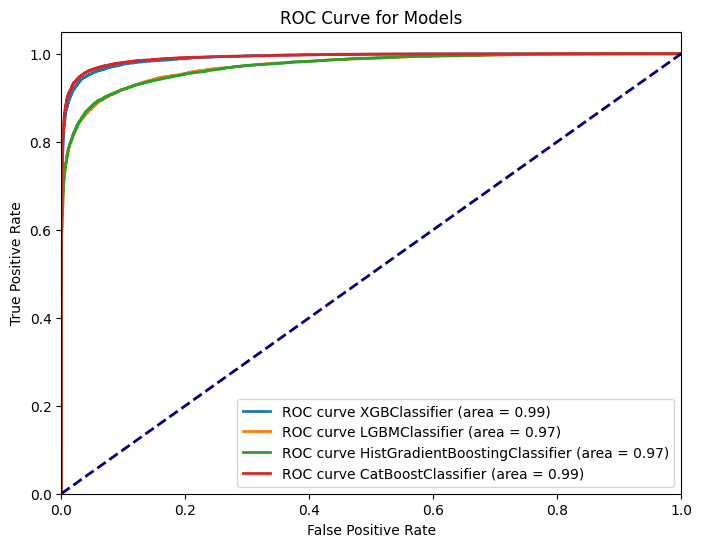

In [60]:
from sklearn.metrics import roc_curve, auc

models = [XGBClassifier(), lgb.LGBMClassifier(), HistGradientBoostingClassifier(), CatBoostClassifier(verbose=0)]
plt.figure(figsize=(8, 6))

for i in range(4):
    models[i].fit(X_train_f, Y_train_f)
    val_predictions = models[i].predict_proba(X_val_f)[:, 1]
    print(f'{models[i]} : ')
    print('Training Accuracy : ', metrics.roc_auc_score(Y_train_f, models[i].predict_proba(X_train_f)[:,1]))
    print('Validation Accuracy : ', metrics.roc_auc_score(Y_val_f, models[i].predict_proba(X_val_f)[:,1]))

    fpr, tpr, thresholds = roc_curve(Y_val_f, val_predictions)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, lw=2, label=f'ROC curve {models[i].__class__.__name__} (area = %0.2f)' % roc_auc)

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Models')
plt.legend(loc="lower right")
plt.show()

In [61]:
from sklearn.metrics import classification_report

models = [XGBClassifier(), lgb.LGBMClassifier(), HistGradientBoostingClassifier(), CatBoostClassifier(verbose=0)]

for i in range(4):
    models[i].fit(X_train_f, Y_train_f)

    print(f'{models[i]} : ')
    print('Training Accuracy : ', metrics.roc_auc_score(Y_train_f, models[i].predict_proba(X_train_f)[:,1]))
    print('Validation Accuracy : ', metrics.roc_auc_score(Y_val_f, models[i].predict_proba(X_val_f)[:,1]))
    print(classification_report(Y_val_f, models[i].predict(X_val_f)))
    print()

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...) : 
Training Accuracy :  0.9954079168142107
Validation Accuracy :  0.9905960565186798
              precision    recall  f1-score   support

           0       0.94      0.97      0.95     14843
           1       0.97      0.94      0.95     

**Model Ensembling:**

In [63]:
from sklearn.metrics import roc_auc_score
# Make predictions with each model
preds_train = [model.predict_proba(X_train_f)[:, 1] for model in models]
preds_val = [model.predict_proba(X_val_f)[:, 1] for model in models]

# Average the predictions
avg_preds_train = np.mean(preds_train, axis=0)
avg_preds_val = np.mean(preds_val, axis=0)

# Evaluate the averaged predictions
print('Ensemble Model : ')
print('Training Accuracy : ', roc_auc_score(Y_train_f, avg_preds_train))
print('Validation Accuracy : ', roc_auc_score(Y_val_f, avg_preds_val))

Ensemble Model : 
Training Accuracy :  0.9931567977299598
Validation Accuracy :  0.9881899401275029


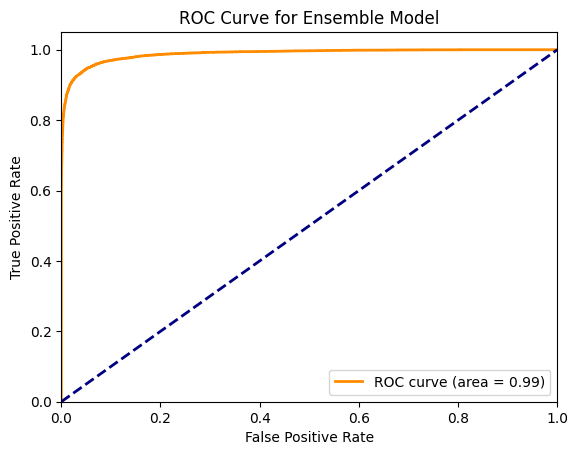

In [64]:
from sklearn.metrics import roc_curve, auc

# Assuming avg_preds_val is defined as in your code snippet
fpr, tpr, thresholds = roc_curve(Y_val_f, avg_preds_val)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Ensemble Model')
plt.legend(loc="lower right")
plt.show()

In [74]:
# Converting probabilities to class labels for classification report
threshold = 0.5
ensemble_preds_val = [1 if prob > threshold else 0 for prob in avg_preds_val]

# Generate and print the classification report
print(classification_report(Y_val_f, ensemble_preds_val))

              precision    recall  f1-score   support

           0       0.92      0.98      0.95     14843
           1       0.97      0.91      0.94     14994

    accuracy                           0.94     29837
   macro avg       0.95      0.94      0.94     29837
weighted avg       0.95      0.94      0.94     29837



In [66]:
X_all = scaler.transform(feature_set)

In [68]:
models[0].fit(X_all, target_variable)
predictions_xgb = models[0].predict_proba(test1)[:,1]

models[1].fit(X_all, target_variable)
predictions_lgb = models[1].predict_proba(test1)[:,1]

models[2].fit(X_all, target_variable)
predictions_hist = models[2].predict_proba(test1)[:,1]

models[3].fit(X_all, target_variable)
predictions_cat = models[3].predict_proba(test1)[:,1]

[LightGBM] [Info] Number of positive: 74592, number of negative: 74592
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024536 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3137
[LightGBM] [Info] Number of data points in the train set: 149184, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


In [69]:
ss = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/energy-anomaly-detection/sample_submission.csv')
ss['anomaly'] = (predictions_xgb + predictions_lgb + predictions_hist)/3
ss.to_csv('Submission_ensemble.csv', index=False)
ss

,row_id,anomaly
0,0,0.072194
1,1,0.105611
2,2,0.123905
3,3,0.140843
4,4,0.124769
...,...,...
1800562,1800562,0.083275
1800563,1800563,0.369133
1800564,1800564,0.061694
1800565,1800565,0.469838


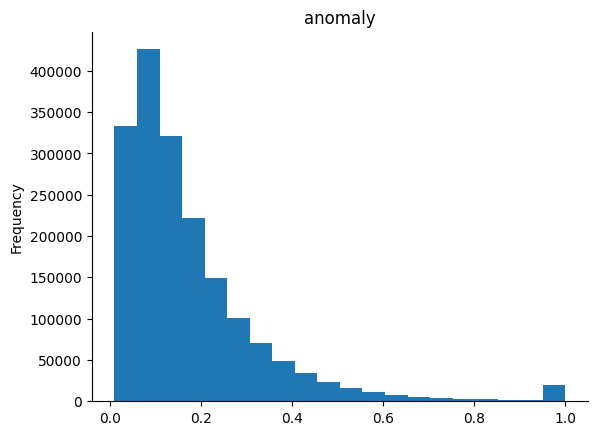

In [70]:
from matplotlib import pyplot as plt
ss['anomaly'].plot(kind='hist', bins=20, title='anomaly')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [71]:
ss.loc[test_f['meter_reading']==1.0, 'anomaly'].describe()

,anomaly
count,17660.000000
mean,0.990031
std,0.051183
min,0.284552
25%,0.997932
50%,0.998854
75%,0.999169
max,0.999758


In [72]:
ss.loc[test_f['meter_reading']==1.0, 'anomaly'] = 1
ss.to_csv('Submission_ensemble_fixed.csv', index=False)
ss

,row_id,anomaly
0,0,0.072194
1,1,0.105611
2,2,0.123905
3,3,0.140843
4,4,0.124769
...,...,...
1800562,1800562,0.083275
1800563,1800563,0.369133
1800564,1800564,0.061694
1800565,1800565,0.469838


In [73]:
ss.loc[test_f['meter_reading']==1.0, 'anomaly'].describe()

,anomaly
count,17660.0
mean,1.0
std,0.0
min,1.0
25%,1.0
50%,1.0
75%,1.0
max,1.0
